<a href="https://colab.research.google.com/github/flotep/bioresponse/blob/branch_FT/bioresponse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Download Kaggle Data in Google Colab.
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()#Choisir le kaggle.json téléchargé : Kaggle > Account > API > Create New API Token

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"floriantep","key":"d3f7d9778ba4e98c535bbad82862ed33"}'}

In [ ]:
#Création d'un dossier kaggle, copie de kaggle.json dedans.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
#Change les permissions du fichier json.
!chmod 600 ~/.kaggle/kaggle.json

kaggle.json


In [ ]:
#!kaggle datasets list
#Téléchargements des données du projet.
!kaggle competitions download -c bioresponse

svm_benchmark.csv: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#Création des dossiers train et test où on extrait les fichiers zip. 
!mkdir train 
!mkdir test
!unzip -q train.csv.zip -d train
!unzip -q test.csv.zip -d test
!ls

mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘test’: File exists
replace train/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
'kaggle (1).json'		 sample_data	     train
'kaggle (2).json'		 svm_benchmark.csv   train.csv.zip
 kaggle.json			 test
 my_first_model_show_shape.png	 test.csv.zip


In [ ]:
import csv
with open('train/train.csv', newline='') as csvfile:
  spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
  for row in spamreader:
    print(', '.join(row))

In [ ]:
import numpy as np
def read_data(file_path):
    with open(file_path) as f:
        f.readline()    # skip header
        samples = []
        for line in f:
            line = line.split(",") #split the string into a list (the separator is the comma)
            sample = [float(x) for x in line]
            samples.append(sample)
    return samples #list of list, each list contains all the descriptor of one molecule (structure and composition).

def load(train_path, test_path, benchmark_path):
    train = read_data(train_path)
    benchmark = read_data(benchmark_path)
    y_train = np.array([x[0] for x in train])#output train : the first colum of each molecules rows "Activty" -> 1 = elicit the biological response, 0 = no biological response
    X_train = np.array([x[1:] for x in train])#input train : every column of the molecules rows, except the 1st column
    X_test = np.array(read_data(test_path))#input test : already without the first column containing the biological response
    y_test = np.array([x[1] for x in benchmark])#output expected for the test
    return X_train, y_train, X_test, y_test

In [ ]:
train_path = 'train/train.csv' #3751 rows, 1777 columns
test_path = 'test/test.csv' #2501 rows, 1776 columns
benchmark_path = 'svm_benchmark.csv'#2501 rows, one value per row (between 0 and 1)

X_train, y, X_test, y_test = load(train_path, test_path, benchmark_path)
#X_train = tf.stack(X_train)
#X_test = tf.stack(X_test)
print(X_train.shape) #input train = 3751 molécules, 1776 colonnes (chaque colonne = 1 descripteur)
print(X_train[0])
print(y.shape) #expected output train = 3751 ligne (1 pour chaque molécule), 1 colonne : prédiction -> probabilité entre 0 et 1
print(y[0])
print(X_test.shape)
print(X_test[0]) #test= 2501 molécules, 1776 colonnes (chaque colonne = 1 descripteur)
print(y_test.shape)
print(y_test[0])

(3751, 1776)
[0.         0.49700901 0.1        ... 0.         0.         0.        ]
(3751,)
1.0
(2501, 1776)
[0.36666667 0.61176451 0.05       ... 0.         1.         0.        ]
(2501,)
0.858294


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Input of the model
input_shape = (1776,) #1776 descriptors
inputs = keras.Input(shape=input_shape)
print(inputs.shape)
print(inputs.dtype)

(None, 1776)
<dtype: 'float32'>


In [ ]:
#Model layers
dense = layers.Dense(64, activation="relu")
hidden1 = dense(inputs)
hidden2 = layers.Dense(64, activation="relu")(hidden1)
outputs = layers.Dense(1, activation ="relu")(hidden2) #shape = 1 -> One value between 0 and 1 (regression)

In [ ]:
model = keras.Model(inputs=inputs, outputs=outputs,name="bioresponse_model2")

In [ ]:
model.summary()

Model: "bioresponse_model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1776)]            0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                113728    
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 117,953
Trainable params: 117,953
Non-trainable params: 0
_________________________________________________________________


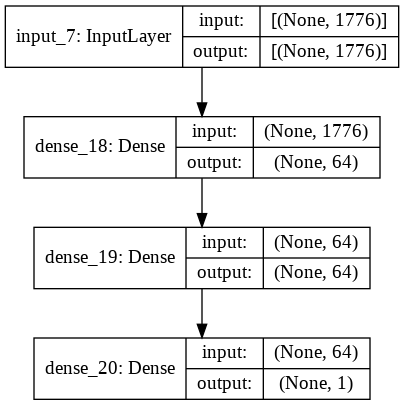

In [ ]:
keras.utils.plot_model(model, "my_first_model_show_shape.png", show_shapes=True)

In [ ]:
#https://stackoverflow.com/questions/42665359/how-do-you-compute-accuracy-in-a-regression-model-after-rounding-predictions-to
from keras import backend as K

def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))



In [ ]:
#Compile model
model.compile(
    #loss=keras.losses.MeanSquaredError(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), #Evaluate the model with the log loss
    optimizer=keras.optimizers.SGD(),
    metrics=[soft_acc] #Compute accuracy for a regression model
    #metrics=["accuracy"]
)

In [ ]:
histori=model.fit(X_train,y, batch_size=64, epochs= 15, validation_split=0.1)

Epoch 1/15
53/53 [==============================] - 1s 5ms/step - loss: 0.6798 - soft_acc: 0.4813 - val_loss: 0.6806 - val_soft_acc: 0.5045
Epoch 2/15
53/53 [==============================] - 0s 3ms/step - loss: 0.6659 - soft_acc: 0.5394 - val_loss: 0.6671 - val_soft_acc: 0.5435
Epoch 3/15
53/53 [==============================] - 0s 4ms/step - loss: 0.6530 - soft_acc: 0.5916 - val_loss: 0.6558 - val_soft_acc: 0.5889
Epoch 4/15
53/53 [==============================] - 0s 3ms/step - loss: 0.6409 - soft_acc: 0.6340 - val_loss: 0.6431 - val_soft_acc: 0.6380
Epoch 5/15
53/53 [==============================] - 0s 3ms/step - loss: 0.6295 - soft_acc: 0.6594 - val_loss: 0.6324 - val_soft_acc: 0.6641
Epoch 6/15
53/53 [==============================] - 0s 3ms/step - loss: 0.6199 - soft_acc: 0.6765 - val_loss: 0.6244 - val_soft_acc: 0.7102
Epoch 7/15
53/53 [==============================] - 0s 3ms/step - loss: 0.6114 - soft_acc: 0.6894 - val_loss: 0.6179 - val_soft_acc: 0.7050
Epoch 8/15
53/53 [==

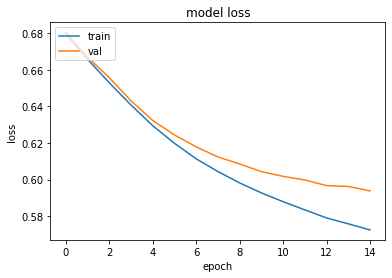

In [ ]:
import matplotlib.pyplot as plt

#Summarize history for loss
plt.plot(histori.history['loss'])
plt.plot(histori.history['val_loss'])
plt.title ('model loss')
plt.ylabel ('loss')
plt.xlabel ('epoch')
plt.legend (['train', 'val'], loc = 'upper left')
plt.show()

In [ ]:
#Test the model
_, acc = model.evaluate(X_test, y_test, verbose=1)
print(acc)

79/79 [==============================] - 0s 1ms/step - loss: 0.6012 - soft_acc: 0.7360
0.7359968423843384
